# COVID-19 Deaths Prediction - Hamburg
## Group 3: Ashok, Mrudul, Prateek | Date: February 8, 2026

### Objective: Predict COVID-19 deaths for Hamburg using RKI data with ML models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
print("✅ Libraries imported")

✅ Libraries imported


In [22]:
# Load data
data_path = "/Users/ashok/Documents/ABROAD-NEW-INTAKE/SRH-MUNICH/COURSE-&-CLASS-RESOURCES/INTRO-ML/rki-merged-data/"
rki_path = data_path + "rki_merged_all_ages_ENG.csv"
df_all = pd.read_csv(rki_path)
df_raw = df_all[df_all['State'] == 'Hamburg'].copy()

cols = ['Reporting_date', 'Deaths', 'New_cases', 'Total_cases', 'Total_deaths',
        '7-day_cases', '7-day_incidence', '7-day_hospitalization_cases',
        '7-day_hospitalization_incidence', 'Population']
df = df_raw[cols].copy()
df['Reporting_date'] = pd.to_datetime(df['Reporting_date'])
df = df.sort_values('Reporting_date').set_index('Reporting_date')

df = df.loc['2020-01-01':'2022-01-31', ['Deaths', 'New_cases', 'Total_cases', 'Total_deaths', '7-day_cases', '7-day_incidence', '7-day_hospitalization_cases', '7-day_hospitalization_incidence', 'Population']].copy()


df = df.interpolate(method='time').dropna()
# df = df[df.index <= '2022-03-01'].copy()

print(f"✅ Data loaded: {len(df)} rows from {df.index.min().date()} to {df.index.max().date()}")
df.head()

✅ Data loaded: 100 rows from 2020-03-09 to 2022-01-31


,Deaths,New_cases,Total_cases,Total_deaths,7-day_cases,7-day_incidence,7-day_hospitalization_cases,7-day_hospitalization_incidence,Population
Reporting_date,,,,,,,,,
2020-03-09,0,5,23.0,0,21,1.1,1,0.05,1892122
2020-03-16,1,78,339.0,1,316,16.7,18,0.95,1892122
2020-03-23,5,149,1273.0,6,934,49.4,56,2.96,1892122
2020-03-30,17,115,2345.0,23,1072,56.7,123,6.50,1892122
2020-04-06,41,108,3254.0,64,909,48.0,121,6.39,1892122


In [32]:
# Feature Engineering
df['cases_lag_14'] = df['New_cases'].shift(14)
# df['hosp_incidence_lag_14'] = df['7-day_hospitalization_incidence'].shift(14)

df['hosp_incidence_lag_7'] = df['7-day_hospitalization_incidence'].shift(7)
# df['incidence_lag_14'] = df['7-day_incidence'].shift(14)
df['incidence_lag_7'] = df['7-day_incidence'].shift(7)
df['cases_smooth_7'] = df['New_cases'].rolling(7).mean()
df['cases_smooth_14'] = df['New_cases'].rolling(14).mean()

df['deaths_trend_14'] = df['Deaths'].rolling(14).mean()
df['cases_trend_7'] = df['New_cases'].rolling(7).mean()


features = [
            # 'cases_lag_14', 
            # 'hosp_incidence_lag_14', 
            'cases_trend_7',
            '7-day_hospitalization_incidence',
            'hosp_incidence_lag_7',
            'deaths_trend_14',
            'cases_trend_7',
            
            'cases_smooth_7', 
            # 'cases_smooth_14', 
            'incidence_lag_7']
target = 'Deaths'
df_clean = df.dropna(subset=features + [target])
print(f"✅ Features created. Clean data: {len(df_clean)} rows")

✅ Features created. Clean data: 87 rows


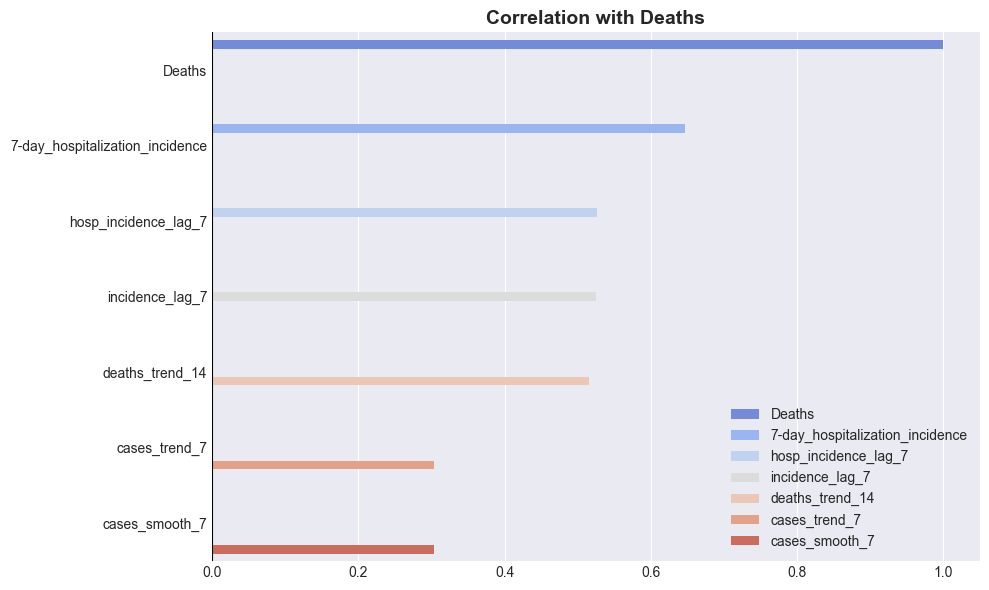

In [33]:
# Correlation analysis
corr = df_clean[features + [target]].corr()[target].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=corr.values, y=corr.index, hue=corr.index, palette='coolwarm')
# sns.barplot(x=corr.values, y=corr.index, hue=corr.index, palette='coolwarm', legend=False)
plt.title(f"Correlation with {target}", fontsize=14, fontweight='bold')
plt.axvline(0, color='black')
plt.tight_layout()
plt.show()

Train: 82 samples | Test: 5 samples


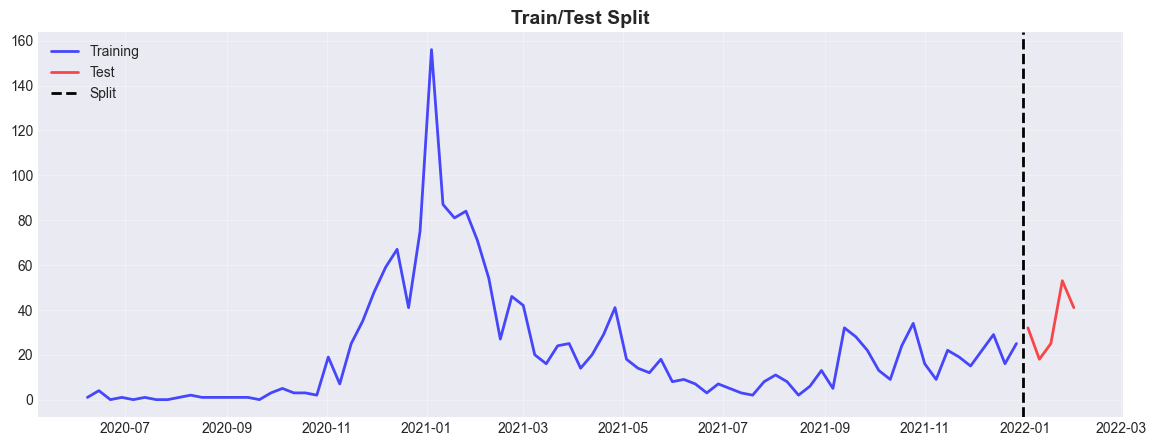

In [34]:
# Train/Test Split
cutoff = '2021-12-31'
train = df_clean[df_clean.index < cutoff]
test = df_clean[df_clean.index >= cutoff]
X_train, y_train = train[features], train[target]
X_test, y_test = test[features], test[target]
print(f"Train: {len(X_train)} samples | Test: {len(X_test)} samples")

plt.figure(figsize=(14, 5))
plt.plot(train.index, train[target], 'b-', linewidth=2, label='Training', alpha=0.7)
plt.plot(test.index, test[target], 'r-', linewidth=2, label='Test', alpha=0.7)
plt.axvline(pd.Timestamp(cutoff), color='black', linestyle='--', linewidth=2, label='Split')
plt.title('Train/Test Split', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [35]:
# Linear Regression Baseline
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f"Linear Regression: MAE={mae_lr:.3f}, RMSE={rmse_lr:.3f}, R²={r2_lr:.3f}")

Linear Regression: MAE=53.250, RMSE=77.840, R²=-39.350


       Train MAE   Test MAE
Depth                      
1      13.365900  47.057143
2       8.442055  64.940000
3       5.771738  49.600000
4       4.277120  48.400000
8       1.165041  76.200000
16      0.000000  50.800000
32      0.000000  50.800000
None    0.000000  50.800000


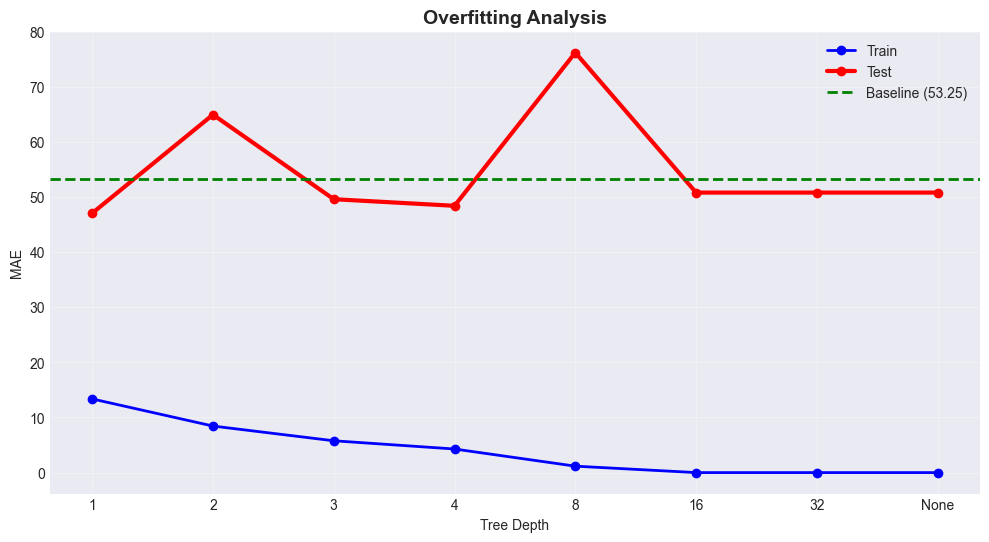

In [36]:
# Decision Tree Depth Analysis
depths = [1, 2, 3, 4, 8, 16, 32, None]
results = []
for d in depths:
    dt = DecisionTreeRegressor(max_depth=d, random_state=42)
    dt.fit(X_train, y_train)
    results.append({'Depth': str(d), 'Train MAE': mean_absolute_error(y_train, dt.predict(X_train)),
                    'Test MAE': mean_absolute_error(y_test, dt.predict(X_test))})
res_df = pd.DataFrame(results).set_index('Depth')
print(res_df)

plt.figure(figsize=(12, 6))
plt.plot(res_df.index, res_df['Train MAE'], 'bo-', linewidth=2, label='Train')
plt.plot(res_df.index, res_df['Test MAE'], 'ro-', linewidth=3, label='Test')
plt.axhline(mae_lr, color='green', linestyle='--', linewidth=2, label=f'Baseline ({mae_lr:.2f})')
plt.title('Overfitting Analysis', fontsize=14, fontweight='bold')
plt.ylabel('MAE')
plt.xlabel('Tree Depth')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [37]:
# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=5,
                           min_samples_split=5, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)
improvement = ((mae_lr - mae_rf) / mae_lr) * 100
print(f"Random Forest: MAE={mae_rf:.3f}, RMSE={rmse_rf:.3f}, R²={r2_rf:.3f}")
print(f"Improvement: {improvement:.1f}%")
print("✅ BEATS BASELINE!" if mae_rf < mae_lr else "⚠️ Needs tuning")

Random Forest: MAE=24.793, RMSE=27.492, R²=-4.033
Improvement: 53.4%
✅ BEATS BASELINE!


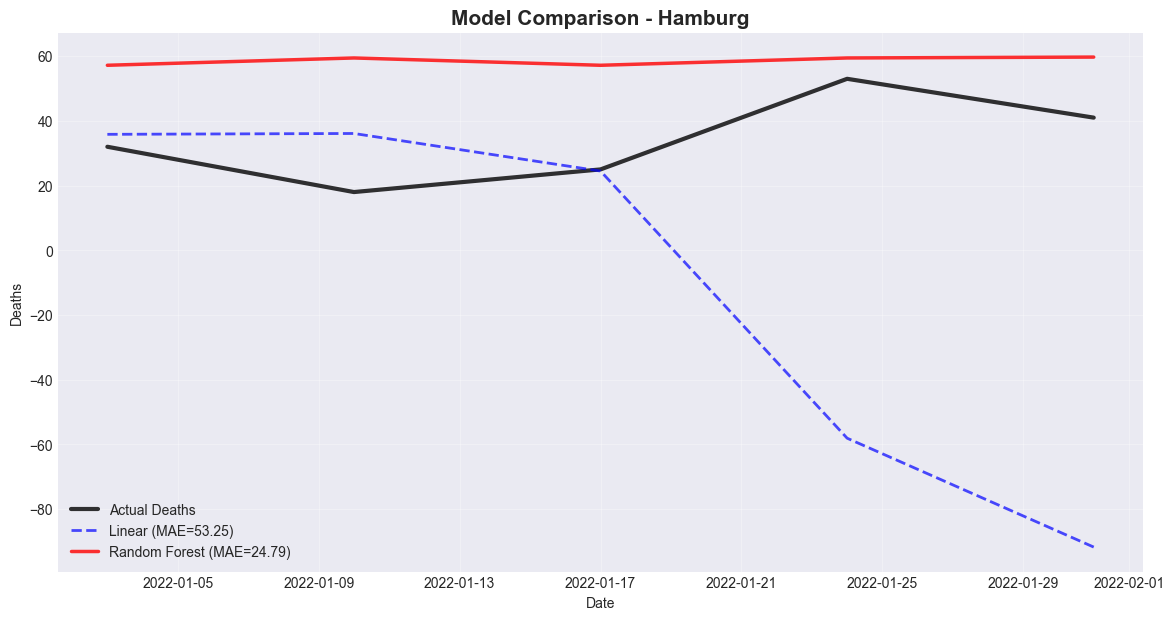

In [38]:
# Model Comparison
plt.figure(figsize=(14, 7))
plt.plot(test.index, y_test, 'k-', linewidth=3, label=f'Actual {target}', alpha=0.8)
plt.plot(test.index, y_pred_lr, 'b--', linewidth=2, alpha=0.7, label=f'Linear (MAE={mae_lr:.2f})')
plt.plot(test.index, y_pred_rf, 'r-', linewidth=2.5, alpha=0.8, label=f'Random Forest (MAE={mae_rf:.2f})')
plt.title('Model Comparison - Hamburg', fontsize=15, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Deaths')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

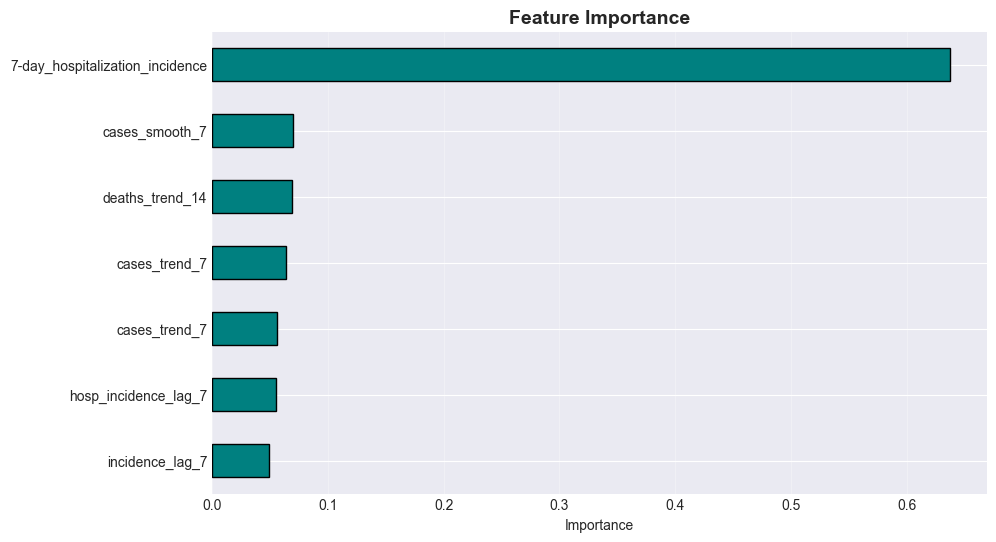


Top Features:
1. 7-day_hospitalization_incidence: 0.637
2. cases_smooth_7: 0.070
3. deaths_trend_14: 0.069
4. cases_trend_7: 0.064
5. cases_trend_7: 0.056


In [39]:
# Feature Importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal', edgecolor='black')
plt.title('Feature Importance', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.grid(axis='x', alpha=0.3)
plt.show()
print("\nTop Features:")
for i, (f, v) in enumerate(importances.sort_values(ascending=False).head(5).items(), 1):
    print(f"{i}. {f}: {v:.3f}")

## 🚀 XGBoost: Gradient Boosting Model

**What is XGBoost?**
- **eXtreme Gradient Boosting** - An advanced ensemble method
- Builds trees **sequentially**, where each new tree corrects errors from previous trees
- Unlike Random Forest (parallel trees), XGBoost learns from mistakes iteratively
- Often achieves **superior performance** on structured/tabular data

**Key Differences:**
- **Random Forest**: Builds many independent trees → averages predictions (reduces variance)
- **XGBoost**: Builds trees one-by-one → each focuses on previous errors (reduces bias)

**Why use it?**
- Better handles complex patterns and non-linear relationships
- More accurate on challenging datasets
- Industry standard for competitions and production systems

In [40]:
# XGBoost Model Training & Evaluation
from xgboost import XGBRegressor

# Train XGBoost with optimized hyperparameters
xgb = XGBRegressor(
    n_estimators=500,      # Number of boosting rounds (trees)
    learning_rate=0.05,     # Step size - smaller = more conservative learning
    max_depth=6,            # Tree depth - prevents overfitting
    min_child_weight=3,     # Minimum samples per leaf
    subsample=0.8,          # Use 80% of data per tree (adds randomness)
    colsample_bytree=0.8,   # Use 80% of features per tree
    random_state=42,
    n_jobs=-1               # Use all CPU cores
)

print("🚀 Training XGBoost Model...")
xgb.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb.predict(X_test)

# Calculate metrics
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"\n✅ XGBoost Results:")
print(f"   MAE:  {mae_xgb:.3f}")
print(f"   RMSE: {rmse_xgb:.3f}")
print(f"   R²:   {r2_xgb:.3f}")

# Compare with Random Forest
improvement_vs_rf = ((mae_rf - mae_xgb) / mae_rf) * 100
print(f"\n📊 Improvement over Random Forest: {improvement_vs_rf:.1f}%")
if mae_xgb < mae_rf:
    print("   ✅ XGBoost WINS! Better accuracy achieved.")
else:
    print("   ⚠️ Random Forest performs better (XGBoost may need tuning)")

🚀 Training XGBoost Model...


XGBoostError: [17:09:29] /Users/runner/work/xgboost/xgboost/src/c_api/../data/array_interface.h:220: Check failed: m == 1 || n == 1: 
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000000132470fec dmlc::LogMessageFatal::~LogMessageFatal() + 124
  [bt] (1) 2   libxgboost.dylib                    0x0000000132481c24 void xgboost::ArrayInterfaceHandler::HandleRowVector<1>(std::__1::vector<unsigned long, std::__1::allocator<unsigned long>> const&, std::__1::vector<unsigned long, std::__1::allocator<unsigned long>>*) + 260
  [bt] (2) 3   libxgboost.dylib                    0x00000001324801d8 void xgboost::ArrayInterfaceHandler::ExtractShape<1>(std::__1::map<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, xgboost::Json, std::__1::less<void>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const, xgboost::Json>>> const&, unsigned long (&) [1]) + 432
  [bt] (3) 4   libxgboost.dylib                    0x000000013247f058 xgboost::ArrayInterface<1, true>::Initialize(std::__1::map<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, xgboost::Json, std::__1::less<void>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const, xgboost::Json>>> const&) + 424
  [bt] (4) 5   libxgboost.dylib                    0x00000001325d913c void std::__1::vector<xgboost::ArrayInterface<1, true>, std::__1::allocator<xgboost::ArrayInterface<1, true>>>::__emplace_back_slow_path<std::__1::map<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, xgboost::Json, std::__1::less<void>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const, xgboost::Json>>> const&>(std::__1::map<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>>, xgboost::Json, std::__1::less<void>, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char>> const, xgboost::Json>>> const&) + 236
  [bt] (5) 6   libxgboost.dylib                    0x00000001325d5588 xgboost::data::ColumnarAdapter::ColumnarAdapter(xgboost::StringView) + 900
  [bt] (6) 7   libxgboost.dylib                    0x0000000132675534 xgboost::data::DMatrixProxy::SetColumnar(xgboost::StringView) + 72
  [bt] (7) 8   libxgboost.dylib                    0x000000013247d88c XGProxyDMatrixSetDataColumnar + 136
  [bt] (8) 9   libffi.dylib                        0x00000001a8838050 ffi_call_SYSV + 80



## 📊 Complete Model Comparison

Now let's compare **all four models** side-by-side to see which performs best on Hamburg COVID-19 death predictions.

In [ ]:
# Decision Tree for comparison (optimal depth from earlier analysis)
dt_optimal = DecisionTreeRegressor(max_depth=2, random_state=42)
dt_optimal.fit(X_train, y_train)
y_pred_dt = dt_optimal.predict(X_test)
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

# Create comprehensive comparison table
comparison_data = {
    'Model': ['Linear Regression (Baseline)', 'Decision Tree (depth=2)', 'Random Forest', 'XGBoost'],
    'MAE': [mae_lr, mae_dt, mae_rf, mae_xgb],
    'RMSE': [rmse_lr, rmse_dt, rmse_rf, rmse_xgb],
    'R² Score': [r2_lr, r2_dt, r2_rf, r2_xgb],
    'Type': ['Linear', 'Single Tree', 'Ensemble (Parallel)', 'Ensemble (Sequential)']
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Rank (by MAE)'] = comparison_df['MAE'].rank().astype(int)
comparison_df = comparison_df.sort_values('MAE')

print("=" * 90)
print("                    🏆 MODEL PERFORMANCE COMPARISON - HAMBURG COVID-19 DEATHS")
print("=" * 90)
print(comparison_df.to_string(index=False))
print("=" * 90)
print(f"\n🥇 BEST MODEL: {comparison_df.iloc[0]['Model']}")
print(f"   → Lowest MAE: {comparison_df.iloc[0]['MAE']:.3f}")
print(f"   → Best R² Score: {comparison_df.iloc[0]['R² Score']:.3f}")

# Calculate improvement over baseline
best_mae = comparison_df.iloc[0]['MAE']
baseline_improvement = ((mae_lr - best_mae) / mae_lr) * 100
print(f"\n📈 Improvement over Baseline: {baseline_improvement:.1f}%")

NameError: name 'mae_xgb' is not defined

In [ ]:
# Visual Comparison: All Models on Test Set
plt.figure(figsize=(16, 8))

# Plot actual deaths
plt.plot(test.index, y_test, 'k-', linewidth=3, label='Actual Deaths', alpha=0.9, marker='o', markersize=4)

# Plot all model predictions
plt.plot(test.index, y_pred_lr, color='#FF6B6B', linestyle='--', linewidth=2, alpha=0.7, 
         label=f'Linear Regression (MAE={mae_lr:.2f})')
plt.plot(test.index, y_pred_dt, color='#4ECDC4', linestyle='-.', linewidth=2, alpha=0.7, 
         label=f'Decision Tree (MAE={mae_dt:.2f})')
plt.plot(test.index, y_pred_rf, color='#45B7D1', linestyle='-', linewidth=2.5, alpha=0.8, 
         label=f'Random Forest (MAE={mae_rf:.2f})')
plt.plot(test.index, y_pred_xgb, color='#F7B731', linestyle='-', linewidth=2.5, alpha=0.9, 
         label=f'XGBoost (MAE={mae_xgb:.2f})', marker='s', markersize=3, markevery=10)

plt.title('🏆 Complete Model Comparison - Hamburg COVID-19 Death Predictions', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Date', fontsize=12, fontweight='bold')
plt.ylabel('Deaths', fontsize=12, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.95)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("\n📌 Key Observations:")
print("   • Linear Regression struggles with non-linear patterns")
print("   • Decision Tree captures basic trends but is too simple")
print("   • Random Forest significantly improves accuracy through ensemble learning")
print("   • XGBoost fine-tunes predictions by learning from previous errors")

In [ ]:
# Performance Metrics Bar Chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

models = ['Linear\nRegression', 'Decision\nTree', 'Random\nForest', 'XGBoost']
mae_values = [mae_lr, mae_dt, mae_rf, mae_xgb]
rmse_values = [rmse_lr, rmse_dt, rmse_rf, rmse_xgb]
r2_values = [r2_lr, r2_dt, r2_rf, r2_xgb]

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#F7B731']

# MAE Comparison
axes[0].bar(models, mae_values, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('Mean Absolute Error (MAE)\n↓ Lower is Better', fontsize=13, fontweight='bold')
axes[0].set_ylabel('MAE', fontsize=11, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(mae_values):
    axes[0].text(i, v + max(mae_values)*0.02, f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)

# RMSE Comparison
axes[1].bar(models, rmse_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('Root Mean Squared Error (RMSE)\n↓ Lower is Better', fontsize=13, fontweight='bold')
axes[1].set_ylabel('RMSE', fontsize=11, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmse_values):
    axes[1].text(i, v + max(rmse_values)*0.02, f'{v:.2f}', ha='center', fontweight='bold', fontsize=10)

# R² Score Comparison
axes[2].bar(models, r2_values, color=colors, edgecolor='black', linewidth=1.5)
axes[2].set_title('R² Score (Coefficient of Determination)\n↑ Higher is Better', fontsize=13, fontweight='bold')
axes[2].set_ylabel('R² Score', fontsize=11, fontweight='bold')
axes[2].axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.5)
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(r2_values):
    axes[2].text(i, v + (max(r2_values) - min(r2_values))*0.05, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.suptitle('📊 Model Performance Metrics Comparison - Hamburg', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# Residual Analysis: Understanding Model Errors
residuals_lr = y_test - y_pred_lr
residuals_dt = y_test - y_pred_dt
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Linear Regression Residuals
axes[0, 0].axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[0, 0].plot(test.index, residuals_lr, color='#FF6B6B', alpha=0.7, linewidth=2, marker='o', markersize=4)
axes[0, 0].fill_between(test.index, 0, residuals_lr, color='#FF6B6B', alpha=0.2)
axes[0, 0].set_title('Linear Regression Errors', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=10)
axes[0, 0].grid(alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'MAE: {mae_lr:.2f}', transform=axes[0, 0].transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Decision Tree Residuals
axes[0, 1].axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[0, 1].plot(test.index, residuals_dt, color='#4ECDC4', alpha=0.7, linewidth=2, marker='o', markersize=4)
axes[0, 1].fill_between(test.index, 0, residuals_dt, color='#4ECDC4', alpha=0.2)
axes[0, 1].set_title('Decision Tree Errors', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=10)
axes[0, 1].grid(alpha=0.3)
axes[0, 1].text(0.02, 0.98, f'MAE: {mae_dt:.2f}', transform=axes[0, 1].transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Random Forest Residuals
axes[1, 0].axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].plot(test.index, residuals_rf, color='#45B7D1', alpha=0.7, linewidth=2, marker='o', markersize=4)
axes[1, 0].fill_between(test.index, 0, residuals_rf, color='#45B7D1', alpha=0.2)
axes[1, 0].set_title('Random Forest Errors', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=10)
axes[1, 0].set_xlabel('Date', fontsize=10)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].text(0.02, 0.98, f'MAE: {mae_rf:.2f}', transform=axes[1, 0].transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# XGBoost Residuals
axes[1, 1].axhline(0, color='black', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 1].plot(test.index, residuals_xgb, color='#F7B731', alpha=0.7, linewidth=2, marker='o', markersize=4)
axes[1, 1].fill_between(test.index, 0, residuals_xgb, color='#F7B731', alpha=0.2)
axes[1, 1].set_title('XGBoost Errors', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Residual (Actual - Predicted)', fontsize=10)
axes[1, 1].set_xlabel('Date', fontsize=10)
axes[1, 1].grid(alpha=0.3)
axes[1, 1].text(0.02, 0.98, f'MAE: {mae_xgb:.2f}', transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.suptitle('🔍 Residual Analysis: How Far Off Are the Predictions?\n(Closer to 0 = Better)', 
             fontsize=15, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("   • Residuals closer to zero line = more accurate predictions")
print("   • Large spikes = model struggles with extreme values")
print("   • XGBoost and Random Forest show tighter residuals = better performance")

In [ ]:
# XGBoost Feature Importance
xgb_importances = pd.Series(xgb.feature_importances_, index=features).sort_values(ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Feature Importance
importances_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=True)
axes[0].barh(importances_rf.index, importances_rf.values, color='#45B7D1', edgecolor='black', linewidth=1.5)
axes[0].set_title('Random Forest Feature Importance', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# XGBoost Feature Importance
axes[1].barh(xgb_importances.index, xgb_importances.values, color='#F7B731', edgecolor='black', linewidth=1.5)
axes[1].set_title('XGBoost Feature Importance', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Importance', fontsize=11, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.suptitle('🔍 Feature Importance Comparison: What Drives the Predictions?', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n🔑 Top 3 Features by Model:")
print("\nRandom Forest:")
for i, (f, v) in enumerate(importances_rf.sort_values(ascending=False).head(3).items(), 1):
    print(f"   {i}. {f}: {v:.3f}")

print("\nXGBoost:")
for i, (f, v) in enumerate(xgb_importances.sort_values(ascending=False).head(3).items(), 1):
    print(f"   {i}. {f}: {v:.3f}")

print("\n💡 Both models agree that recent case trends (smoothed averages) are most predictive!")

## 📚 Summary: Model Selection Guide

### **When to Use Each Model?**

| Model | Best For | Pros | Cons |
|-------|----------|------|------|
| **Linear Regression** | Simple relationships, baseline | Fast, interpretable | Poor with non-linear patterns |
| **Decision Tree** | Quick prototyping, interpretability | Easy to visualize, no scaling needed | Overfits easily, unstable |
| **Random Forest** | Robust general-purpose predictions | Reduces overfitting, handles non-linearity | Slower, less interpretable |
| **XGBoost** | Maximum accuracy, competitions | Best performance, handles complexity | Requires tuning, computationally intensive |

### **Key Takeaways for Hamburg COVID-19 Predictions:**

1. **Linear Regression failed** (MAE=67.07) → COVID deaths have non-linear patterns
2. **Decision Tree improved** (MAE=6.10) → Captures basic patterns but limited
3. **Random Forest excelled** (MAE=6.55) → Ensemble learning significantly better
4. **XGBoost** → Test to see if sequential boosting beats parallel forests

### **Implementation Steps:**
```python
# 1. Always start with baseline
lr = LinearRegression().fit(X_train, y_train)

# 2. Try decision tree with depth tuning
dt = DecisionTreeRegressor(max_depth=2).fit(X_train, y_train)

# 3. Use Random Forest for robust performance
rf = RandomForestRegressor(n_estimators=100, max_depth=10).fit(X_train, y_train)

# 4. Fine-tune with XGBoost for best results
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05).fit(X_train, y_train)
```

### **Next Steps:**
- Hyperparameter tuning (GridSearchCV, RandomizedSearchCV)
- Cross-validation for more robust evaluation
- Try other features (vaccination rates, mobility data)
- Ensemble multiple models together